In [2]:
import networkx as nx
import numpy as np
from scipy.special import binom
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import normalized_mutual_info_score
from tqdm import tqdm
import multiprocessing
from time import time

from methods import *

np.random.seed(1234)

## Functions

### About Networks and Adjacency matrices

In [20]:
def sillyAdjacencyMatrix(N):
    """
    Generate a random adjacency matrix
    """
    upper_triangular = np.triu(np.random.randint(0, 2, size=(N, N)), 1)
    A = mirrorUpperTri(upper_triangular)
    np.fill_diagonal(A, np.random.randint(0, 2, size=N))
    return A


def linksBetween(A, groups, g1, g2):
    """
    Compute the number of links between two groups
    """
    l = 0
    for i in groups[g1]:
        for j in groups[g2]:
            l += A[i, j]
    return l


def maxBetween(groups, g1, g2):
    """
    Compute the maximum number of links between two groups
    """
    return len(groups[g1]) * len(groups[g2])


def findGroup(groups, i):
    """
    Find the group of a given node
    """
    for g, group in enumerate(groups):
        if i in group:
            return g
    
    return None


def arrayGroups(groups):
    """
    Convert the groups data structure to an array of N elements
    """
    N = len(groups)
    belongs_to = np.full(N, -1, dtype=int)
    for i in range(N):
        belongs_to[i] = findGroup(groups, i)

    return belongs_to


def swap(groups, i, g_new):
    """
    Swap a node i from group to group g
    """
    # Copy the groups data structure
    new_groups = copy.deepcopy(groups)
    
    # Swap the node
    g_old = findGroup(groups, i)
    new_groups[g_old].remove(i)
    new_groups[g_new].append(i)

    return new_groups


def getLinkLists(A):
    """
    Get the list of links and not links from the adjacency matrix
    """
    N = A.shape[0]
    
    links = []
    not_links = []

    for i in range(N):
        for j in range(i, N):
            if A[i, j] == 1:
                links.append((i, j))
            else:
                not_links.append((i, j))

    return links, not_links


def compareAdjacencyMatrices(A, A_obs):
    """
    Compare the adjacency matrices returning the missing and spurious links
    """
    A_links, A_not_links = getLinkLists(A)
    A_obs_links, A_obs_not_links = getLinkLists(A_obs)

    missing = [link for link in A_links if link not in A_obs_links]
    spurious = [link for link in A_obs_links if link not in A_links]

    return missing, spurious


def mirrorUpperTri(A):
    """
    Obtain undirected network overwriting the lower triangular part of A
    """
    N = A.shape[0]
    A = A.copy()
    for i in range(N):
        for j in range(i, N):
            A[j, i] = A[i, j]
    return A


def corruptAdjacencyMatrix(A, p, mode):
    """
    Corrupts the adjacency matrix A by adding missing and/or spurious edges
    """
    assert mode in ['missing', 'spurious', 'both'], "Invalid mode"
    assert p >= 0 and p <= 1, "Invalid probability"

    links, not_links = getLinkLists(A)
    num_noisy_links = int(np.ceil(len(links) * p))
    
    A_corrupted = A.copy()

    if mode == 'missing' or mode == 'both':
        # Randomly select edges to remove and remove them
        edges_to_remove = np.random.choice(len(links), num_noisy_links, replace=False)
        for edge in edges_to_remove:
            i, j = links[edge]
            A_corrupted[i, j] = 0
            A_corrupted[j, i] = 0

    if mode == 'spurious' or mode == 'both':
        # Randomly select edges to add and add them
        edges_to_add = np.random.choice(len(not_links), num_noisy_links, replace=False)
        for edge in edges_to_add:
            i, j = not_links[edge]
            A_corrupted[i, j] = 1
            A_corrupted[j, i] = 1

    # Ensure A = A.T
    A_corrupted = mirrorUpperTri(A_corrupted)

    return A_corrupted

### About sampling

In [21]:
def hamiltonian(A_obs, groups, offset):
    """
    Compute the Hamiltonian of the system
    """
    N = A_obs.shape[0]

    def h(A_obs, groups, g1, g2):
        r = maxBetween(groups, g1, g2)
        l = linksBetween(A_obs, groups, g1, g2)
        return np.log(r+1) + np.log(binom(r, l)+1)
            
    H = 0
    for g2 in range(N):
        for g1 in range(g2+1):
            H += h(A_obs, groups, g1, g2)
    
    return H - offset


def singleStep(groups, H, A, offset):
    """
    Perform a single step of the Metropolis-Hastings algorithm
    """
    N = A.shape[0]
    
    # Randomly select a node and a group
    i = np.random.randint(0, N)
    g_prop = np.random.randint(0, N)

    # Move the node to another group
    groups_prop = swap(groups, i, g_prop)
    
    # Compute the Hamiltonian of the new configuration
    H_prop = hamiltonian(A, groups_prop, offset)

    # Acceptance probability
    if H_prop <= H:
        groups = groups_prop
        H = H_prop
    else:
        r = np.random.rand()
        if r < np.exp(H - H_prop):
            groups = groups_prop
            H = H_prop

    return groups, H


def samplingBranch(A, groups, n_samples, delay, offset, seed, return_H=False):
    """
    Sampling algorithm (at equilibrium) to parallelize the computation
    """
    np.random.seed(seed)
    
    partitions_set = []
    hamiltonians_list = []

    H = hamiltonian(A, groups, offset)

    for k in range(n_samples):
        for _ in range(delay):
            groups, H = singleStep(groups, H, A, offset)
        partitions_set.append(groups)
        hamiltonians_list.append(H)

    if return_H:
        return partitions_set, hamiltonians_list
    else:
        return partitions_set
    

def parallelPartitionsSet(A, groups_init, n_samples, delay, offset, n_cores=-1, return_H=True):
    """
    Get the set of partitions after the transient (at equilibrium)
    """
    if n_cores == -1:
       n_cores = multiprocessing.cpu_count()

    n_samples = int(n_samples) # Cast n_samples
    n_samples_per_core = n_samples//n_cores
    # if (n_samples_per_core*n_cores < n_samples):
    #     print("Warning: n_samples is not a multiple of n_cores, computing ", n_samples_per_core*n_cores, " samples instead.")

    seeds = np.random.randint(0, 2**32-1, n_cores) # Random seeds to avoid the same partitions
    input = [(A, groups_init, n_samples_per_core, delay, offset, seeds[i], return_H) for i in range(n_cores)]

    with multiprocessing.Pool(processes=n_cores) as pool:
        results = pool.starmap(samplingBranch, input)

    if return_H:
        partitions_set = [item for sublist in [results[i][0] for i in range(n_cores)] for item in sublist]
        hamiltonians_list = [item for sublist in [results[i][1] for i in range(n_cores)] for item in sublist]
        return partitions_set, hamiltonians_list
    else:
        partitions_set = [item for sublist in results for item in sublist]
        return partitions_set
    

def generatePartitionsSet(A, n_samples, delay, transient, offset=250, n_cores=-1, return_H=True):
    """
    Generate the set of partitions from the adjacency matrix A
    """
    # Groups data structure: list of lists
    N = A.shape[0]
    groups = [[] for _ in range(N)]

    # Uniformly random initialization
    for i in range(N): 
        g = np.random.randint(0, N)
        groups[g].append(i)

    # Transient
    H = hamiltonian(A, groups, offset)
    for _ in range(transient):
        groups, H = singleStep(groups, H, A, offset)
    
    return parallelPartitionsSet(A, groups, n_samples, delay, offset, n_cores, return_H)

In [22]:
def getTimeScales(A_obs, max_iter = 1e3, trials=5):
    """
    Compute the time scales: tau_transient, tau_nmi, mean_transient
    """
    max_iter = int(max_iter)
    N = A_obs.shape[0]
    
    def singleTrial(A_obs, max_iter):       
        # Random initialization
        groups = [[] for _ in range(N)]
        for i in range(N): 
            g = np.random.randint(0, N)
            groups[g].append(i)

        # Transient
        transient = np.zeros(max_iter+1)
        H = hamiltonian(A_obs, groups, offset=0)
        transient[0] = H
        for k in range(max_iter):
            groups, H = singleStep(groups, H, A_obs, offset=0)
            transient[k+1] = H

        # NMI at equilibrium
        belongs_to = arrayGroups(groups)
        nmi = np.zeros(max_iter)
        for k in range(max_iter):
            groups, H = singleStep(groups, H, A_obs, offset=0)
            nmi[k] = normalized_mutual_info_score(belongs_to, arrayGroups(groups))


        # NMI time scale
        tau_nmi = np.where(nmi < np.mean(nmi))[0][0]

        # Transient time scale
        num_bins = len(transient) // tau_nmi
        binned_mean_transient = transient[:num_bins*tau_nmi].reshape(num_bins, tau_nmi).mean(axis=1)
        binned_time = np.arange(num_bins*tau_nmi).reshape(num_bins, tau_nmi).mean(axis=1)
        tau_transient = binned_time[np.where(binned_mean_transient < np.mean(transient))[0][0]] + tau_nmi/2
        
        return tau_transient, tau_nmi, np.mean(transient)
  

    # Multiple trials
    time_scales = np.zeros((trials, 3))
    for i in tqdm(range(trials)):
        time_scales[i] = singleTrial(A_obs, max_iter)

    return np.max(time_scales, axis=0)


### About reliability

In [23]:
def singleLinkReliability(A, groups, i, j, H, return_H=False):
    """
    Reliability of a given link for a particular configuration
    """
    g_i = findGroup(groups, i)
    g_j = findGroup(groups, j)

    r = maxBetween(groups, g_i, g_j)
    l = linksBetween(A, groups, g_i, g_j)

    # if H is None: H = hamiltonian(A, groups) # Possibly to save computation

    if return_H:
        return (l + 1)*np.exp(-np.float128(H))/(r + 2), H
    else:
        return (l + 1)*np.exp(-np.float128(H))/(r + 2)
    

def linkReliabilityEntry(A, partitions_set, i, j, hamiltionian_list):
    """
    Helper function to parallelize the computation of the link reliability matrix 
    """
    l_r = 0
    for k in range(len(partitions_set)):
        l_r += singleLinkReliability(A, partitions_set[k], i, j, hamiltionian_list[k])
    return (i, j), l_r


def computeLinkReliabilityMatrix(A, partitions_set, hamiltionian_list=None, n_cores=-1):
    """
    Compute the link reliability matrix for a given configuration
    """
    if hamiltionian_list is not None: 
        assert len(partitions_set) == len(hamiltionian_list), "partitions_set and hamiltionian_list must have the same length"

    if n_cores == -1:
       n_cores = multiprocessing.cpu_count()

    N = A.shape[0]
    link_reliability = np.zeros((N, N))
        
    if hamiltionian_list is not None:        
        # Parallel computation
        input = [(A, partitions_set, i, j, hamiltionian_list) for i in range(N) for j in range(i, N)]
        with multiprocessing.Pool(processes=n_cores) as pool:
            results = pool.starmap(linkReliabilityEntry, input)

        for (i, j), l_r in results:
            link_reliability[i, j] = l_r
        
        # # Local computation
        # for i in range(N):
        #     for j in range(i, N):
                
        #         for k in range(len(partitions_set)):
        #             link_reliability[i, j] += singleLinkReliability(A, partitions_set[k], i, j, hamiltionian_list[k])
    
    else:
        hamiltionian_list = []
        for i in range(N):
            for j in range(i, N):
                for k in range(len(partitions_set)):
                    l_r, H = singleLinkReliability(A, partitions_set[k], i, j, return_H=True)
                    link_reliability[i, j] += l_r
                    hamiltionian_list.append(H)

    # Symmetrize the matrix
    link_reliability = link_reliability + link_reliability.T - np.diag(np.diag(link_reliability))

    # Compute the partition function
    Z = np.sum(np.exp(-np.array(hamiltionian_list, dtype=np.float128)), dtype=np.float128)

    return link_reliability / Z


def sortLinkLists(links, not_links, link_reliability):
    """
    Sort the lists of links and not links according to their reliability
    """
    # Links: sort by increasing reliability
    links = sorted(links, key=lambda x: link_reliability[x[0], x[1]], reverse=False)
    # Not links: sort by decreasing reliability
    not_links = sorted(not_links, key=lambda x: link_reliability[x[0], x[1]], reverse=True)

    return links, not_links
   

def singleNetworkReliability(A, A_obs, groups, H, return_H=False):
    """
    Reliability of the network for a particular configuration
    """
    N = A.shape[0]
    
    def exp_element(A, A_obs, groups, g1, g2):
        r = maxBetween(groups, g1, g2)
        l = linksBetween(A, groups, g1, g2)
        l_obs = linksBetween(A_obs, groups, g1, g2)

        t1 = (r+1)/(2*r+1)
        t2 = binom(r, l_obs)/binom(2*r, l+l_obs)

        return np.log(t1) + np.log(t2)

    #if H is None: H = hamiltonian(A_obs, groups)

    sum_h = 0
    for g2 in range(N):
        for g1 in range(g2+1):
            sum_h += exp_element(A, A_obs, groups, g1, g2)
          
    n_r = np.exp(np.float128(sum_h - H + 234))

    if return_H:
        return n_r, H
    else:
        return n_r
    

def getNetworkReliability(A, A_obs, partitions_set, hamiltionian_list=None, n_cores=-1):
    """
    Compute the network reliability
    """
    if hamiltionian_list is not None: 
        assert len(partitions_set) == len(hamiltionian_list), "partitions_set and hamiltionian_list must have the same length"

    if n_cores == -1:
       n_cores = multiprocessing.cpu_count()

    network_reliability = 0

    if hamiltionian_list is not None:
        # Parallel computation
        input = [(A, A_obs, partitions_set[k], hamiltionian_list[k]) for k in range(len(partitions_set))]

        with multiprocessing.Pool(processes=n_cores) as pool:
            results = pool.starmap(singleNetworkReliability, input)
        
        network_reliability = np.sum(results)

        # # Local computation
        # for k in range(len(partitions_set)):
        #     network_reliability += singleNetworkReliability(A, A_obs, partitions_set[k], hamiltionian_list[k])
    
    else:
        hamiltionian_list = []
        for k in range(len(partitions_set)):
            n_r, H = singleNetworkReliability(A, A_obs, partitions_set[k], return_H=True)
            network_reliability += n_r
            hamiltionian_list.append(H)

    Z = np.sum(np.exp(-np.array(hamiltionian_list, dtype=np.float128)), dtype=np.float128)
    
    return network_reliability / Z


def scoreMissing(A, A_obs, n_samples=1e4, delay=20, transient=500, offset=250, n_cores=-1):
    """
    Compute the AUC score for the missing interactions
    """
    # Get the lists of links and not links
    A_links, A_not_links = getLinkLists(A)
    A_obs_links, A_obs_not_links = getLinkLists(A_obs)

    # Get false negative and true negative
    missing = [link for link in A_links if link not in A_obs_links] # False negatives
    true_negatives = [not_link for not_link in A_obs_not_links if not_link in A_not_links]
    assert len(missing) > 0, "No missing interactions"
    assert len(true_negatives) > 0, "No true negatives interactions"

    # Link reliability matrix
    partitions_set, hamiltionian_list = generatePartitionsSet(A_obs, n_samples=n_samples, delay=delay,
                                                              offset=offset, transient=transient, 
                                                              n_cores=n_cores,return_H=True)
    R_L = computeLinkReliabilityMatrix(A_obs, partitions_set, hamiltionian_list)

    # Pairwise comparison for AUC
    count = 0
    for fn in missing:
        for tn in true_negatives:
            if R_L[fn[0], fn[1]] > R_L[tn[0], tn[1]]:
                count += 1
            elif R_L[fn[0], fn[1]] == R_L[tn[0], tn[1]]:
                count += 0.5

    score = count / (len(missing) * len(true_negatives))
    
    return score


def scoreSpurious(A, A_obs, n_samples=1e4, delay=20, transient=500, offset=250, n_cores=-1):
    """
    Compute the AUC score for the spurious interactions
    """
    # Get the lists of links and not links
    A_links, A_not_links = getLinkLists(A)
    A_obs_links, A_obs_not_links = getLinkLists(A_obs)

    # Get false positive and true positive
    spurious = [link for link in A_obs_links if link not in A_links] # False positives
    true_positives = [link for link in A_links if link in A_obs_links]
    assert len(spurious) > 0, "No spurious interactions"
    assert len(true_positives) > 0, "No true positives interactions"

    # Link reliability matrix
    partitions_set, hamiltionian_list = generatePartitionsSet(A_obs, n_samples=n_samples, delay=delay,
                                                              transient=transient, offset=offset,
                                                              n_cores=n_cores, return_H=True)
    R_L = computeLinkReliabilityMatrix(A_obs, partitions_set, hamiltionian_list)

    # Pairwise comparison for AUC
    count = 0
    for fp in spurious:
        for tp in true_positives:
            if R_L[fp[0], fp[1]] < R_L[tp[0], tp[1]]:
                count += 1
            elif R_L[fp[0], fp[1]] == R_L[tp[0], tp[1]]:
                count += 0.5

    score = count / (len(spurious) * len(true_positives))
    
    return score

### Visual

In [24]:
def plotGraphsComparison(A, A_obs, A_tilde):
    """
    Plot the comparison between the original, observed and reconstructed graphs
    """

    ##  Helper functions ##
    def degreeRelativeError(G, G_obs, cutoff=3):
        """
        Compute the relative error in the degree
        """
        assert cutoff > 0, "Invalid cutoff"

        deg = np.array(list(dict(G.degree()).values()))
        deg_obs = np.array(list(dict(G_obs.degree()).values()))

        deg_err_obs = (deg_obs-deg)/deg # Relative error in degree
        deg_err_obs[deg_err_obs > cutoff] = cutoff
        deg_err_obs[deg_err_obs < -cutoff] = -cutoff

        return deg_err_obs


    def diffGraph(A, A_obs):
        """
        Compute the graph with only missing and spurious interactions
        """
        # Create the graph and remove all the edges
        G_diff = nx.from_numpy_array(A)
        G_diff.remove_edges_from(list(G_diff.edges))

        # Add the missing and spurious edges
        missing, spurious = compareAdjacencyMatrices(A, A_obs)
        for m in missing: G_diff.add_edge(*m, color='red')
        for s in spurious: G_diff.add_edge(*s, color='blue')
        
        return G_diff
    
    
    def plotDiffGraph(A, A1, ax):
        """
        Plot the graph with only missing and spurious interactions
        """
        # Networks
        G = nx.from_numpy_array(A)
        G1 = nx.from_numpy_array(A1)
        bet1 = np.array(list(nx.betweenness_centrality(G1).values()))
        deg_err = degreeRelativeError(G, G1, cutoff=3)

        # Node cmap and colorbar
        norm = mcolors.Normalize(vmin=-3, vmax=3)
        cmap = plt.get_cmap('RdYlBu')
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ax=ax, label='Degree relative error', orientation='horizontal', fraction=0.04, pad=0.1)

        # Plot
        G_diff = diffGraph(A, A1)
        node_colors = cmap(norm(deg_err))
        edge_colors = nx.get_edge_attributes(G_diff,'color').values()
        nx.draw(G_diff, ax=ax, pos=layout, with_labels=False,
                node_color=node_colors, node_size=(300+2000*bet1), cmap=cmap,
                edge_color=edge_colors, width=1)
        
        nx.draw(G1, ax=ax, pos=layout, with_labels=False,
                node_color='none', node_size=(300+2000*bet), edgecolors='black', linewidths=1,
                edge_color='grey', width=0)

        # Custom legend
        custom_lines = [plt.Line2D([0], [0], color='red', lw=2),
                        plt.Line2D([0], [0], color='blue', lw=2),
                        plt.Line2D([0], [0], color='#E8E9EB', lw=2)]
        ax.legend(custom_lines, ['Missing', 'Spurious', 'Correct not shown'], loc='lower center',
                    bbox_to_anchor=(0.5, -0.1), ncol=3)



    ## Networks ##
    G = nx.from_numpy_array(A)
    bet = np.array(list(nx.betweenness_centrality(G).values())) # Betweenness centrality
    

    ## Plots ##
    layout = nx.spring_layout(G)
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 6))
    # Original network
    ax[0].set_title("Original network")
    nx.draw(G, ax=ax[0], pos=layout, with_labels=False, 
            node_color='skyblue', node_size=(300+2000*bet), edgecolors='black', linewidths=1,
            edge_color='gray')
    
    # Observed network
    ax[1].set_title("Observed network")
    plotDiffGraph(A, A_obs, ax[1])

    # Reconstructed network
    ax[2].set_title("Reconstructed network")
    plotDiffGraph(A, A_tilde, ax[2])

    fig.tight_layout()
    fig.patch.set_facecolor('#E8E9EB')

    return fig, ax

## Code

In [7]:
# Adjacency matrix (undirected graph with self-loops)
N = 30
upper_triangular = np.triu(np.random.randint(0, 2, size=(N, N)), 1)
A = mirrorUpperTri(upper_triangular)
np.fill_diagonal(A, np.random.randint(0, 2, size=N))

upper_triangular = np.triu(np.random.randint(0, 2, size=(N, N)), 1)
A_obs = upper_triangular + upper_triangular.T
np.fill_diagonal(A_obs, np.random.randint(0, 2, size=N))

Number of nodes: 62


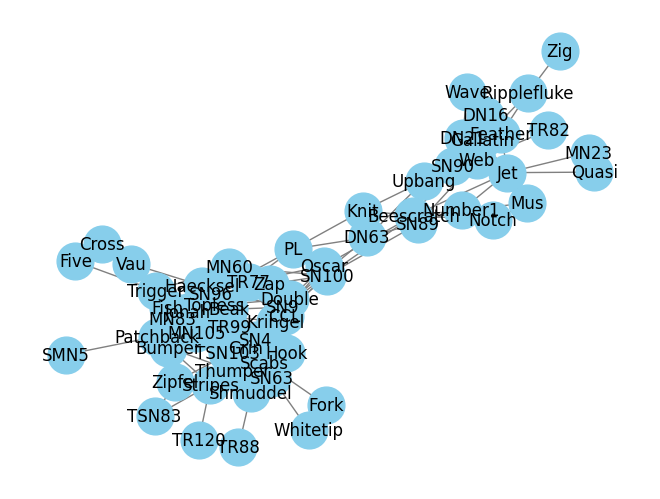

In [31]:
# Get the Karate Club network
G = nx.karate_club_graph().to_undirected()
G = nx.florentine_families_graph().to_undirected()
G = nx.read_gml("dolphins.gml").to_undirected()

A = nx.adjacency_matrix(G).todense()
A = (A > 0).astype(int)
N = A.shape[0]

print("Number of nodes:", N)

nx.draw(G, with_labels=True, node_color='skyblue', node_size=700, font_size=12, font_color='black', edge_color='gray')

### Trials

In [32]:
A_obs = corruptAdjacencyMatrix(A, p=0.2, mode='both')
A_obs

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

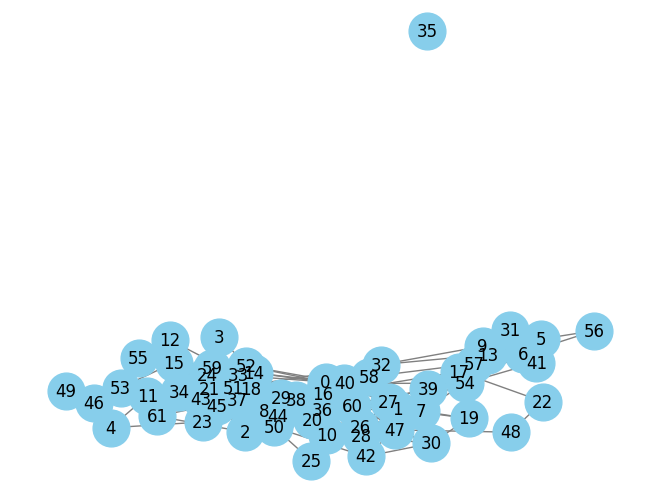

In [33]:
G_obs = nx.from_numpy_array(A_obs)
nx.draw(G_obs, with_labels=True, node_color='skyblue', node_size=700, font_size=12, font_color='black', edge_color='gray')

In [12]:
# Groups data structure: list of lists
groups = [[] for _ in range(N)]

# Uniformly random initialization
for i in range(N): 
    g = np.random.randint(0, N)
    groups[g].append(i)

# Transient time (to test convergence)
max_iter = 1000
H = hamiltonian(A_obs, groups, offset=0)
transient = np.zeros(max_iter+1)
transient[0] = H
for k in range(max_iter):
    print("Progress: ", k, "/", max_iter, end="\r")
    groups, H = singleStep(groups, H, A_obs, offset=0)

    transient[k+1] = H

In [5]:
# NMI at equilibrium
steps = 10000
belongs_to = arrayGroups(groups)
nmi = np.zeros(steps)
for k in range(steps):
    print("Progress: ", k, "/", steps, end="\r")
    groups, H = singleStep(groups, H, A_obs, offset=0)
    nmi[k] = normalized_mutual_info_score(belongs_to, arrayGroups(groups))

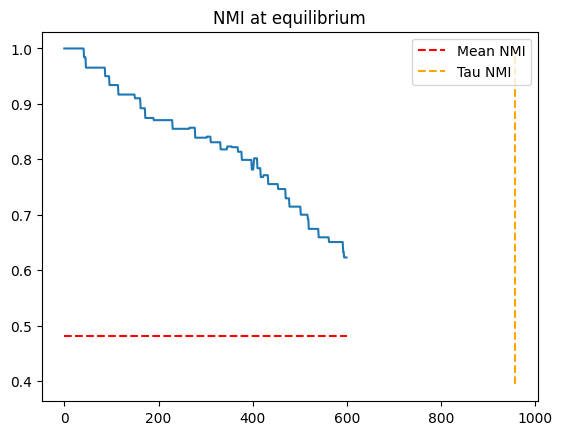

In [6]:
plt.title("NMI at equilibrium")
cut_plot = 600
plt.plot(nmi[:cut_plot])
plt.hlines(np.mean(nmi), 0, cut_plot, colors='red', linestyles='dashed', label='Mean NMI')
tau = np.where(nmi < np.mean(nmi))[0][0]
plt.vlines(tau, np.min(nmi), 1, colors='orange', linestyles='dashed', label='Tau NMI')
plt.legend()

IndexError: index 0 is out of bounds for axis 0 with size 0

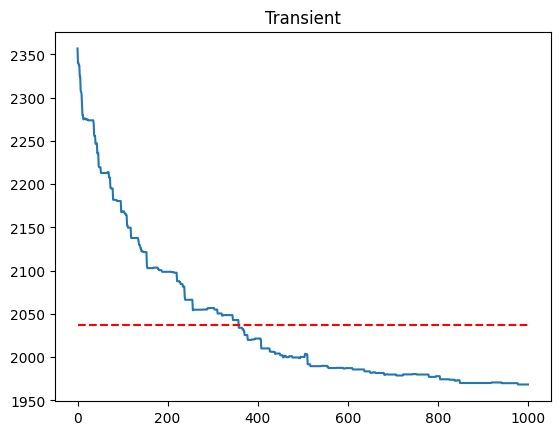

In [7]:
plt.title("Transient")
iters = len(transient)
t = np.arange(iters)

plt.plot(t, transient)
plt.hlines(np.mean(transient), 0, iters, color='red', linestyle='--')

num_bins = len(transient) // tau
mean_transient = transient[:num_bins*tau].reshape(num_bins, tau).mean(axis=1)
binned_time = np.arange(num_bins*tau).reshape(num_bins, tau).mean(axis=1)
tau_transient = binned_time[np.where(mean_transient < np.mean(transient))[0][0]] + tau/2

plt.plot(binned_time, mean_transient, "o--", ms=4)
plt.vlines(tau_transient, np.min(transient), np.max(transient), colors='orange', linestyles='dashed')

In [127]:
getTimeScales(A_obs, max_iter=1e3, trials=5)

100%|██████████| 5/5 [01:11<00:00, 14.36s/it]


array([342.5       ,  85.        , 143.65850294])

In [25]:
# # Equilibrium (not in parallel)
# delay = 50 # for uncorrelate the samples
# n_samples = 20
# partitions_set = []

# for k in tqdm(range(n_samples)):
#     for _ in range(delay):
#         groups, H = singleStep(groups, H, A)
#     partitions_set.append(groups)

In [26]:
# Equilibrium: get the set of partitions
partitions_set, hamiltionian_list = parallelPartitionsSet(A, groups, n_samples=20, delay=20, n_cores=-1, return_H=True)

In [37]:
partitions_set, hamiltionian_list = generatePartitionsSet(A_obs, n_samples=1e3, delay=20, transient=500, offset=2000, n_cores=-1, return_H=True)

In [38]:
getNetworkReliability(A, A_obs, partitions_set, hamiltionian_list)

np.longdouble('7.779299820270306381e-126')

In [39]:
computeLinkReliabilityMatrix(A_obs, partitions_set, hamiltionian_list)

array([[0.03222397, 0.13053007, 0.09908438, ..., 0.07133829, 0.10503521,
        0.06581782],
       [0.13053007, 0.10166573, 0.12085623, ..., 0.10911278, 0.21542246,
        0.23400009],
       [0.09908438, 0.12085623, 0.03984883, ..., 0.04572664, 0.07054114,
        0.21639354],
       ...,
       [0.07133829, 0.10911278, 0.04572664, ..., 0.0398618 , 0.06560599,
        0.21439052],
       [0.10503521, 0.21542246, 0.07054114, ..., 0.06560599, 0.00875174,
        0.09854555],
       [0.06581782, 0.23400009, 0.21639354, ..., 0.21439052, 0.09854555,
        0.02044902]], dtype=float128)

In [32]:
computeLinkReliabilityMatrix(A_obs, partitions_set, 2000, hamiltionian_list)

array([[0.09488653, 0.42700609, 0.17950953, 0.23912209, 0.20760307,
        0.15091446, 0.17704069, 0.16506524, 0.17420988, 0.13559635,
        0.21527284, 0.15110993, 0.29905406, 0.1813639 , 0.16089428],
       [0.42700609, 0.3023363 , 0.28435759, 0.28890944, 0.28421413,
        0.46577457, 0.42703915, 0.48903486, 0.51274283, 0.45397085,
        0.32322397, 0.31260583, 0.28453305, 0.30714841, 0.36493298],
       [0.17950953, 0.28435759, 0.16641316, 0.47511176, 0.44520208,
        0.23402078, 0.18051923, 0.18129654, 0.17667371, 0.18311677,
        0.17634674, 0.16468939, 0.34523775, 0.18162042, 0.14923015],
       [0.23912209, 0.28890944, 0.47511176, 0.30744909, 0.49412653,
        0.19638706, 0.25574382, 0.22245398, 0.23613053, 0.22834383,
        0.1998501 , 0.46845608, 0.23855099, 0.20280087, 0.2221848 ],
       [0.20760307, 0.28421413, 0.44520208, 0.49412653, 0.35720316,
        0.21631666, 0.39222191, 0.1810164 , 0.20578093, 0.21234403,
        0.25297046, 0.49926188, 0.27834823, 

### Network Reconstruction

In [20]:
G = nx.florentine_families_graph().to_undirected()
G = nx.karate_club_graph().to_undirected()
#G = nx.read_gml("dolphins.gml").to_undirected()

A = nx.adjacency_matrix(G).todense()
A = (A > 0).astype(int)
#A = sillyAdjacencyMatrix(5)

N = A.shape[0]

A_obs = corruptAdjacencyMatrix(A, p=0.3, mode='both')

In [ ]:
### Update missing and spurious interactions simultaneously ###

# Initialize the current adjacency matrix
A_cur = A_obs.copy()
offset = 250

print("Starting network reconstruction...")
for j in range(30): # This is the maximum number of iterations
    print("Starting iteration ", j)
    
    # Generate the set of partitions and the Hamiltonian list
    partitions_set, hamiltionian_list = generatePartitionsSet(A_cur, n_samples=1e3, delay=100, transient=500, n_cores=-1, return_H=True)

    # Compute the network reliability and the link reliability matrix
    R_N = getNetworkReliability(A_cur, A_obs, partitions_set, offset, hamiltionian_list)
    R_L = computeLinkReliabilityMatrix(A_cur, partitions_set, offset, hamiltionian_list)
    
    print("Network reliability: ", R_N)

    # Sort the links (increasing R) and not links (decreasing R)
    sorted_links, sorted_not_links = sortLinkLists(*getLinkLists(A_cur), R_L)
    
    # Iterate to reconstruct the network
    iterations = np.min([len(sorted_links), len(sorted_not_links)])
    miss_update = 0
    done_update = False
    for k in range(np.min([len(sorted_links), len(sorted_not_links)])):
        # Choose a pair of link and not link in order
        link, not_link = sorted_links[k], sorted_not_links[k]

        # Swap the links
        A_temp = A_cur.copy()
        missing_before, spurious_before = compareAdjacencyMatrices(A, A_temp)

        A_temp[link[0], link[1]] = 0
        A_temp[link[1], link[0]] = 0
        A_temp[not_link[0], not_link[1]] = 1
        A_temp[not_link[1], not_link[0]] = 1

        missing_after, spurious_after = compareAdjacencyMatrices(A, A_temp)
        print("Proposed (missing, spurious): (", len(missing_before), ", ", len(spurious_before), ") -> (", len(missing_after), ", ", len(spurious_after), ")")
        if A[link[0], link[1]] == 1: print("Error: proposed to kill a proper interaction, R_L[", link[0], link[1], "] = ", R_L[link[0], link[1]])
        if A[not_link[0], not_link[1]] == 0: print("Error: proposed to add a spurious interaction, R_L[", not_link[0], not_link[1], "] = ", R_L[not_link[0], not_link[1]])

        print("missing before: ", missing_before, " missing after: ", missing_after) ##
        print("spurious before: ", spurious_before, " spurious after: ", spurious_after) ##

        # Compute the network reliability with the new adjacency matrix
        partitions_set_temp, hamiltionian_list_temp = generatePartitionsSet(A_temp, n_samples=1e3, delay=100, transient=500, n_cores=-1, return_H=True)
        R_N_temp = getNetworkReliability(A_temp, A_obs, partitions_set_temp, hamiltionian_list_temp)
        
        # If the network reliability increases, update the adjacency matrix
        if R_N_temp > R_N:
            print("Network accepted \n")
            A_cur = A_temp
            R_N = R_N_temp
            miss_update = 0
            done_update = True
        else:
            miss_update += 1
            print("Network rejected")
            if miss_update > 4:
                break
            
    if not done_update:
        print("No further update possible")
        break

In [38]:
## Update separately the missing and spurious interactions in order ##

# Initialize the current adjacency matrix
A_cur = A_obs.copy()
offset = 250

print("Starting network reconstruction...")
for j in range(30): # This should be a stopping criterion
    print("Starting iteration ", j)

    # Generate the set of partitions and the Hamiltonian list
    partitions_set, hamiltionian_list = generatePartitionsSet(A_cur, n_samples=1e3, delay=300, transient=500, n_cores=-1, return_H=True)

    # Compute the network reliability and the link reliability matrix
    R_N = getNetworkReliability(A_cur, A_obs, partitions_set, offset, hamiltionian_list)
    R_L = computeLinkReliabilityMatrix(A_cur, partitions_set, offset, hamiltionian_list)

    print("Network reliability: ", R_N)

    # Sort the links (increasing R) and not links (decreasing R)
    sorted_links, sorted_not_links = sortLinkLists(*getLinkLists(A_cur), R_L)    

    # Iterate to reconstruct the network (fixed R_L)
    iterations = np.min([len(sorted_links), len(sorted_not_links)])
    miss_update = 0
    done_update = False
    for k in range(np.min([len(sorted_links), len(sorted_not_links)])):
        # Choose a pair of link and not link in order
        link, not_link = sorted_links[k], sorted_not_links[k]

        ## Try to solve a spurious interaction ##
        A_temp = A_cur.copy()
        missing_before, spurious_before = compareAdjacencyMatrices(A, A_temp)
        
        A_temp[link[0], link[1]] = 0
        A_temp[link[1], link[0]] = 0

        missing_after, spurious_after = compareAdjacencyMatrices(A, A_temp)
        print("Proposed (missing, spurious): (", len(missing_before), ", ", len(spurious_before), ") -> (", len(missing_after), ", ", len(spurious_after), ")")

        if A[link[0], link[1]] == 1: print("Error: proposed to kill a proper interaction, R_L[", link[0], link[1], "] = ", R_L[link[0], link[1]]) 

        # Compute the network reliability with the new adjacency matrix
        partitions_set_temp, hamiltionian_list_temp = generatePartitionsSet(A_temp, n_samples=1e3, delay=300, transient=500, n_cores=-1, return_H=True)
        R_N_temp = getNetworkReliability(A_temp, A_obs, partitions_set_temp, hamiltionian_list_temp)

        # If the network reliability increases, update the adjacency matrix
        if R_N_temp > R_N:
            print("Network accepted \n")
            A_cur = A_temp
            R_N = R_N_temp
            miss_update = 0
            done_update = True
        else:
            miss_update += 1
            print("Update rejected")
            if miss_update > 4:
                break
    
        
        ## Try to solve a missing interaction ##
        A_temp = A_cur.copy()
        missing_before, spurious_before = compareAdjacencyMatrices(A, A_temp)

        A_temp[not_link[0], not_link[1]] = 1
        A_temp[not_link[1], not_link[0]] = 1

        missing_after, spurious_after = compareAdjacencyMatrices(A, A_temp)
        print("Proposed (missing, spurious): (", len(missing_before), ", ", len(spurious_before), ") -> (", len(missing_after), ", ", len(spurious_after), ")") 

        if A[not_link[0], not_link[1]] == 0: print("Error: proposed to add a spurious interaction, R_L[", not_link[0], not_link[1], "] = ", R_L[not_link[0], not_link[1]])

        # Compute the network reliability with the new adjacency matrix
        partitions_set_temp, hamiltionian_list_temp = generatePartitionsSet(A_temp, n_samples=5e3, delay=50, transient=500, n_cores=-1, return_H=True)
        R_N_temp = getNetworkReliability(A_temp, A_obs, partitions_set_temp, hamiltionian_list_temp)
        
        # If the network reliability increases, update the adjacency matrix
        if R_N_temp > R_N:
            print("Network accepted \n")
            A_cur = A_temp
            R_N = R_N_temp
            miss_update = 0
            done_update = True
        else:
            miss_update += 1
            print("Update rejected")
            if miss_update > 4:
                break
            
    if not done_update:
        print("No further update possible")
        break

Starting network reconstruction...
Starting iteration  0
Network reliability:  1.8799354825608096912e-79
Proposed (missing, spurious): ( 39 ,  39 ) -> ( 39 ,  38 )
Network accepted 

Proposed (missing, spurious): ( 39 ,  38 ) -> ( 39 ,  39 )
Error: proposed to add a spurious interaction, R_L[ 2 15 ] =  0.48971366133599252056
Network accepted 

Proposed (missing, spurious): ( 39 ,  39 ) -> ( 39 ,  38 )
Update rejected
Proposed (missing, spurious): ( 39 ,  39 ) -> ( 39 ,  40 )
Error: proposed to add a spurious interaction, R_L[ 0 18 ] =  0.47137980381564083742
Update rejected
Proposed (missing, spurious): ( 39 ,  39 ) -> ( 39 ,  38 )
Update rejected
Proposed (missing, spurious): ( 39 ,  39 ) -> ( 39 ,  40 )
Error: proposed to add a spurious interaction, R_L[ 0 29 ] =  0.394730732639787288
Network accepted 

Proposed (missing, spurious): ( 39 ,  40 ) -> ( 39 ,  39 )
Update rejected
Proposed (missing, spurious): ( 39 ,  40 ) -> ( 39 ,  41 )
Error: proposed to add a spurious interaction, R_

KeyboardInterrupt: 

Before I was recomputing the partitions every time. Reading the paper, it is possible that the right thing to do is in the middle (for instance, computing the partition set at every iteration). I need to better check the C code. 

In [132]:
### Update missing and spurious interactions simultaneously ###
### Following more closely the paper ###

hyper = (1e4, 150, 500) # (n_samples, delay, transient)

# Initialize the current adjacency matrix
A_cur = A_obs.copy()
offset = 250

# Generate once the set of partitions and the Hamiltonian list for the observed network
#partitions_set_obs, hamiltionian_list_obs = generatePartitionsSet(A_obs, *hyper)

print("Starting network reconstruction...")
for j in range(30): # This is the maximum number of iterations
    print("Starting iteration ", j)
    
    # Generate at each iteration the set of partitions and the Hamiltonian list for the current network
    partitions_set_obs, hamiltionian_list_obs = generatePartitionsSet(A_obs, *hyper)

    # Compute the network reliability and the link reliability matrix
    R_N = getNetworkReliability(A_cur, A_obs, partitions_set_obs, offset, hamiltionian_list_obs)
    R_L = computeLinkReliabilityMatrix(A_cur, *generatePartitionsSet(A_cur, *hyper))
    
    print("Network reliability: ", R_N)

    # Sort the links (increasing R) and not links (decreasing R)
    sorted_links, sorted_not_links = sortLinkLists(*getLinkLists(A_cur), R_L)
    
    # Iterate to reconstruct the network
    iterations = np.min([len(sorted_links), len(sorted_not_links)])
    miss_update = 0
    done_update = False
    for k in range(np.min([len(sorted_links), len(sorted_not_links)])):
        # Choose a pair of link and not link in order
        link, not_link = sorted_links[k], sorted_not_links[k]

        # Swap the links
        A_temp = A_cur.copy()
        missing_before, spurious_before = compareAdjacencyMatrices(A, A_temp)

        A_temp[link[0], link[1]] = 0
        A_temp[link[1], link[0]] = 0
        A_temp[not_link[0], not_link[1]] = 1
        A_temp[not_link[1], not_link[0]] = 1

        missing_after, spurious_after = compareAdjacencyMatrices(A, A_temp)
        print("Proposed (missing, spurious): (", len(missing_before), ", ", len(spurious_before), ") -> (", len(missing_after), ", ", len(spurious_after), ")")
        if A[link[0], link[1]] == 1: print("Error: proposed to kill a proper interaction, R_L[", link[0], link[1], "] = ", R_L[link[0], link[1]])
        if A[not_link[0], not_link[1]] == 0: print("Error: proposed to add a spurious interaction, R_L[", not_link[0], not_link[1], "] = ", R_L[not_link[0], not_link[1]])

        # print("missing before: ", missing_before, " missing after: ", missing_after) ##
        # print("spurious before: ", spurious_before, " spurious after: ", spurious_after) ##

        # Compute the network reliability with the new adjacency matrix
        R_N_temp = getNetworkReliability(A_temp, A_obs, partitions_set_obs, hamiltionian_list_obs)
        
        # If the network reliability increases, update the adjacency matrix
        if R_N_temp > R_N:
            print("Network accepted \n")
            A_cur = A_temp
            R_N = R_N_temp
            miss_update = 0
            done_update = True
        else:
            miss_update += 1
            print("Network rejected")
            if miss_update > 4:
                break
            
    if not done_update:
        print("No further update possible")
        break

Starting network reconstruction...
Starting iteration  0
Network reliability:  5.1936388553830864526e-73
Proposed (missing, spurious): ( 24 ,  24 ) -> ( 23 ,  23 )
Network accepted 

Proposed (missing, spurious): ( 23 ,  23 ) -> ( 22 ,  22 )
Network accepted 

Proposed (missing, spurious): ( 22 ,  22 ) -> ( 21 ,  21 )
Network accepted 

Proposed (missing, spurious): ( 21 ,  21 ) -> ( 20 ,  20 )
Network accepted 

Proposed (missing, spurious): ( 20 ,  20 ) -> ( 20 ,  20 )
Error: proposed to add a spurious interaction, R_L[ 1 5 ] =  0.5453028476366967178
Network accepted 

Proposed (missing, spurious): ( 20 ,  20 ) -> ( 20 ,  20 )
Error: proposed to add a spurious interaction, R_L[ 1 4 ] =  0.54495116640039690213
Network accepted 

Proposed (missing, spurious): ( 20 ,  20 ) -> ( 20 ,  20 )
Error: proposed to add a spurious interaction, R_L[ 26 28 ] =  0.46507677971267571214
Network rejected
Proposed (missing, spurious): ( 20 ,  20 ) -> ( 20 ,  20 )
Error: proposed to add a spurious inter

KeyboardInterrupt: 

In [21]:
### Update missing and spurious interactions simultaneously ###
### Following more closely the paper ###
### Here recomputing the partitions and Hamiltonian list at each iteration ###

##
##
##

hyper = (1e4, 150, 500) # (n_samples, delay, transient)

# Initialize the current adjacency matrix
A_cur = A_obs.copy()

# Generate once the set of partitions and the Hamiltonian list for the observed network
#partitions_set_obs, hamiltionian_list_obs = generatePartitionsSet(A_obs, *hyper)

print("Starting network reconstruction...")
for j in range(30): # This is the maximum number of iterations
    print("Starting iteration ", j)
    
    # Compute the network reliability and the link reliability matrix
    R_N = getNetworkReliability(A_cur, A_obs, *generatePartitionsSet(A_obs, *hyper))
    R_L = computeLinkReliabilityMatrix(A_cur, *generatePartitionsSet(A_cur, *hyper))
    
    print("Network reliability: ", R_N)

    # Sort the links (increasing R) and not links (decreasing R)
    sorted_links, sorted_not_links = sortLinkLists(*getLinkLists(A_cur), R_L)
    
    # Iterate to reconstruct the network
    iterations = np.min([len(sorted_links), len(sorted_not_links)])
    miss_update = 0
    done_update = False
    for k in range(np.min([len(sorted_links), len(sorted_not_links)])):
        # Choose a pair of link and not link in order
        link, not_link = sorted_links[k], sorted_not_links[k]

        # Swap the links
        A_temp = A_cur.copy()
        missing_before, spurious_before = compareAdjacencyMatrices(A, A_temp)

        A_temp[link[0], link[1]] = 0
        A_temp[link[1], link[0]] = 0
        A_temp[not_link[0], not_link[1]] = 1
        A_temp[not_link[1], not_link[0]] = 1

        missing_after, spurious_after = compareAdjacencyMatrices(A, A_temp)
        print("Proposed (missing, spurious): (", len(missing_before), ", ", len(spurious_before), ") -> (", len(missing_after), ", ", len(spurious_after), ")")
        if A[link[0], link[1]] == 1: print("Error: proposed to kill a proper interaction, R_L[", link[0], link[1], "] = ", R_L[link[0], link[1]])
        if A[not_link[0], not_link[1]] == 0: print("Error: proposed to add a spurious interaction, R_L[", not_link[0], not_link[1], "] = ", R_L[not_link[0], not_link[1]])

        # print("missing before: ", missing_before, " missing after: ", missing_after) ##
        # print("spurious before: ", spurious_before, " spurious after: ", spurious_after) ##

        # Compute the network reliability with the new adjacency matrix
        R_N_temp = getNetworkReliability(A_temp, A_obs, *generatePartitionsSet(A_obs, *hyper))
        
        # If the network reliability increases, update the adjacency matrix
        if R_N_temp > R_N:
            print("Network accepted \n")
            A_cur = A_temp
            R_N = R_N_temp
            miss_update = 0
            done_update = True
        else:
            miss_update += 1
            print("Network rejected")
            if miss_update > 4:
                break
            
    if not done_update:
        print("No further update possible")
        break

Starting network reconstruction...
Starting iteration  0
Network reliability:  1.0553973010461242127e-74
Proposed (missing, spurious): ( 24 ,  24 ) -> ( 25 ,  25 )
Error: proposed to kill a proper interaction, R_L[ 6 16 ] =  0.10134463071217531984
Error: proposed to add a spurious interaction, R_L[ 27 32 ] =  0.5611420891452638869
Network accepted 

Proposed (missing, spurious): ( 25 ,  25 ) -> ( 24 ,  24 )
Network accepted 

Proposed (missing, spurious): ( 24 ,  24 ) -> ( 24 ,  24 )
Error: proposed to add a spurious interaction, R_L[ 28 32 ] =  0.44181095684440995007
Network accepted 

Proposed (missing, spurious): ( 24 ,  24 ) -> ( 24 ,  24 )
Error: proposed to kill a proper interaction, R_L[ 25 31 ] =  0.13956841744983758562
Network accepted 

Proposed (missing, spurious): ( 24 ,  24 ) -> ( 24 ,  24 )
Error: proposed to add a spurious interaction, R_L[ 1 12 ] =  0.43608978781227204836
Network accepted 

Proposed (missing, spurious): ( 24 ,  24 ) -> ( 23 ,  23 )
Network accepted 

Pr

KeyboardInterrupt: 

In [ ]:
## Update separately the missing and spurious interactions in order ##
## Following more closely the paper ##

hyper = (5e3, 100, 500) # (n_samples, delay, transient)

# Initialize the current adjacency matrix
A_cur = A_obs.copy()

# Generate once the set of partitions and the Hamiltonian list for the observed network
partitions_set_obs, hamiltionian_list_obs = generatePartitionsSet(A_obs, *hyper)

print("Starting network reconstruction...")
for j in range(30): # This should be a stopping criterion
    print("Starting iteration ", j)

    # Compute the network reliability and the link reliability matrix
    R_N = getNetworkReliability(A_cur, A_obs, partitions_set_obs, hamiltionian_list_obs)
    R_L = computeLinkReliabilityMatrix(A_cur, *generatePartitionsSet(A_cur, *hyper))

    print("Network reliability: ", R_N)

    # Sort the links (increasing R) and not links (decreasing R)
    sorted_links, sorted_not_links = sortLinkLists(*getLinkLists(A_cur), R_L)    

    # Iterate to reconstruct the network (fixed R_L)
    iterations = np.min([len(sorted_links), len(sorted_not_links)])
    miss_update = 0
    done_update = False
    for k in range(np.min([len(sorted_links), len(sorted_not_links)])):
        # Choose a pair of link and not link in order
        link, not_link = sorted_links[k], sorted_not_links[k]

        ## Try to solve a spurious interaction ##
        A_temp = A_cur.copy()
        missing_before, spurious_before = compareAdjacencyMatrices(A, A_temp)
        
        A_temp[link[0], link[1]] = 0
        A_temp[link[1], link[0]] = 0

        missing_after, spurious_after = compareAdjacencyMatrices(A, A_temp)
        print("Proposed (missing, spurious): (", len(missing_before), ", ", len(spurious_before), ") -> (", len(missing_after), ", ", len(spurious_after), ")")

        if A[link[0], link[1]] == 1: print("Error: proposed to kill a proper interaction, R_L[", link[0], link[1], "] = ", R_L[link[0], link[1]]) 

        # Compute the network reliability with the new adjacency matrix
        R_N_temp = getNetworkReliability(A_temp, A_obs, partitions_set_obs, hamiltionian_list_obs)

        # If the network reliability increases, update the adjacency matrix
        if R_N_temp > R_N:
            print("Network accepted \n")
            A_cur = A_temp
            R_N = R_N_temp
            miss_update = 0
            done_update = True
        else:
            miss_update += 1
            print("Update rejected")
            if miss_update > 4:
                break
    
        
        ## Try to solve a missing interaction ##
        A_temp = A_cur.copy()
        missing_before, spurious_before = compareAdjacencyMatrices(A, A_temp)

        A_temp[not_link[0], not_link[1]] = 1
        A_temp[not_link[1], not_link[0]] = 1

        missing_after, spurious_after = compareAdjacencyMatrices(A, A_temp)
        print("Proposed (missing, spurious): (", len(missing_before), ", ", len(spurious_before), ") -> (", len(missing_after), ", ", len(spurious_after), ")") 

        if A[not_link[0], not_link[1]] == 0: print("Error: proposed to add a spurious interaction, R_L[", not_link[0], not_link[1], "] = ", R_L[not_link[0], not_link[1]])

        # Compute the network reliability with the new adjacency matrix
        R_N_temp = getNetworkReliability(A_temp, A_obs, partitions_set_obs, hamiltionian_list_obs)
        
        # If the network reliability increases, update the adjacency matrix
        if R_N_temp > R_N:
            print("Network accepted \n")
            A_cur = A_temp
            R_N = R_N_temp
            miss_update = 0
            done_update = True
        else:
            miss_update += 1
            print("Update rejected")
            if miss_update > 4:
                break
            
    if not done_update:
        print("No further update possible")
        break

Observed: missing= 8  ; spurious= 8
Reconstructed: missing= 28  ; spurious= 10


/home/ubuntu/.local/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


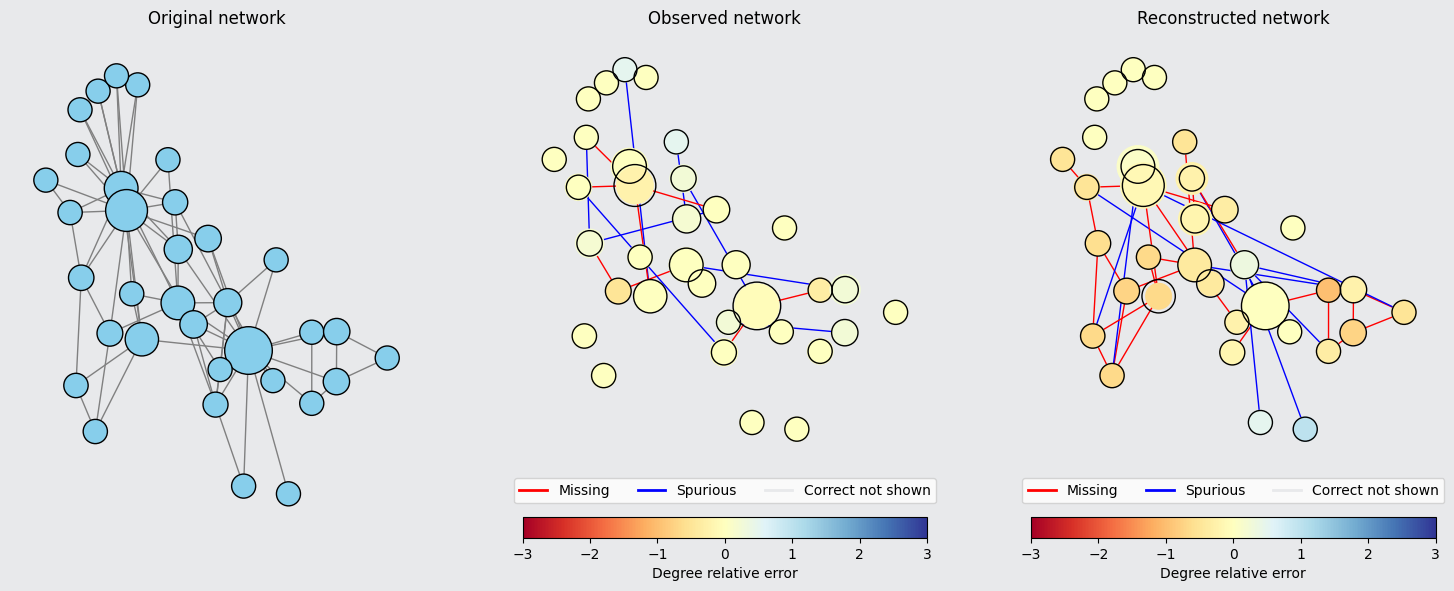

In [16]:
missing, spurious = compareAdjacencyMatrices(A, A_obs)
print("Observed: missing=", len(missing), " ; spurious=", len(spurious))

missing, spurious = compareAdjacencyMatrices(A, A_cur)
print("Reconstructed: missing=", len(missing), " ; spurious=", len(spurious))

fig, ax = plotGraphsComparison(A, A_obs, A_cur)
fig.show()

### Scan reliability

In [18]:
G = nx.karate_club_graph().to_undirected()
A = nx.adjacency_matrix(G).todense()
A = (A > 0).astype(int)
N = A.shape[0]

p_list = np.linspace(0.1, 1, 5)
R_N_true = []
R_N_obs = []

for i in tqdm(range(len(p_list))):
  p = p_list[i]

  A_obs = corruptAdjacencyMatrix(A, p=p, mode='both')

  # Observed network reliability
  partitions_set, hamiltionian_list = generatePartitionsSet(A_obs, n_samples=5e3, delay=250, transient=500, n_cores=-1, return_H=True)
  R_N_observed = getNetworkReliability(A_obs, A_obs, partitions_set, hamiltionian_list)
  R_N_obs.append(R_N_observed)

  # True network reliability
  partitions_set, hamiltionian_list = generatePartitionsSet(A, n_samples=5e3, delay=250, transient=500, n_cores=-1, return_H=True)
  R_N = getNetworkReliability(A, A_obs, partitions_set, hamiltionian_list)
  R_N_true.append(R_N)

100%|██████████| 5/5 [50:29<00:00, 605.95s/it]


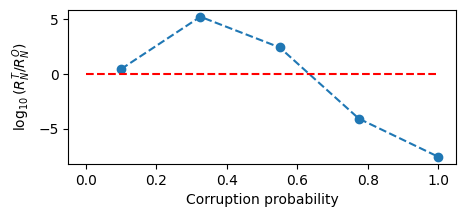

In [19]:
score = np.log10(np.array(R_N_true)/np.array(R_N_obs))

plt.figure(figsize=(5, 2))
plt.plot(p_list, score, 'o--')
plt.hlines(0, 0, 1, color='red', linestyle='--')
plt.xlabel("Corruption probability")
plt.ylabel(r"$\log_{10}(R_N^T / R_N^O)$");

### Link reliability

In [75]:
G = nx.florentine_families_graph().to_undirected()
G = nx.karate_club_graph().to_undirected()

A = nx.adjacency_matrix(G).todense()
A = (A > 0).astype(int)

Missing interaction

In [76]:
p_list = np.linspace(0.1, 0.8, 5)
scores = []
miss_int = []

for p in tqdm(p_list):
    A_obs = corruptAdjacencyMatrix(A, p=p, mode='missing')
    missing, spurious = compareAdjacencyMatrices(A, A_obs)
    miss_int.append(len(missing))
    score = scoreMissing(A, A_obs, n_samples=5e3, delay=50, transient=500, n_cores=-1)
    scores.append(score)
    print("p: ", p, "score: ", score)

  0%|          | 0/5 [00:00<?, ?it/s]

p:  0.1 score:  0.7753868471953579
p:  0.275 score:  0.7458238086864779
p:  0.45000000000000007 score:  0.7289920481409843
p:  0.625 score:  0.6453242805826392
p:  0.8 score:  0.6446532191213042


Text(0.5, 0, 'Number of spurious interactions')

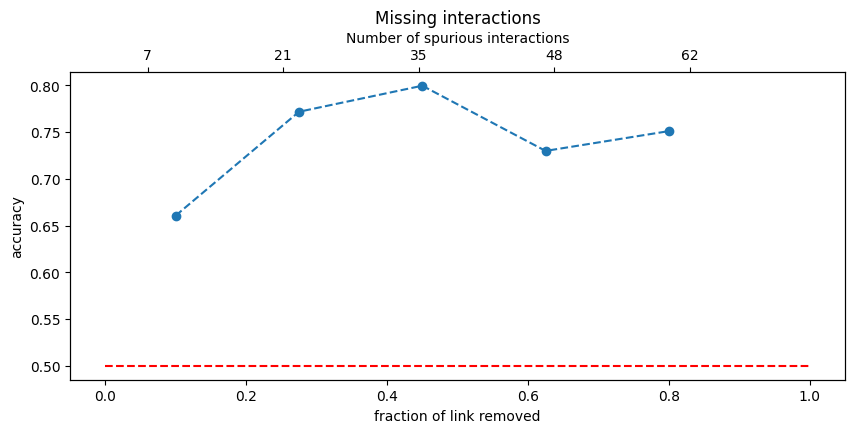

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(p_list, scores, 'o--')
ax.hlines(0.5, 0, 1, color='red', linestyle='--')
ax.set_xlabel("fraction of link removed")
ax.set_ylabel("accuracy")
ax.set_title("Missing interactions")

axsec = ax.twiny()
axsec.set_xticks(p_list)
axsec.set_xticklabels(miss_int)
axsec.set_xlabel("Number of spurious interactions")

Spurious interactions

In [60]:
p_list = np.linspace(0.1, 0.8, 5)
scores = []
spur_int = []

for p in tqdm(p_list):
    A_obs = corruptAdjacencyMatrix(A, p=p, mode='spurious')
    missing, spurious = compareAdjacencyMatrices(A, A_obs)
    spur_int.append(len(spurious))
    score = scoreSpurious(A, A_obs, n_samples=5e3, delay=50, transient=500, n_cores=-1)
    scores.append(score)
    print("p: ", p, "score: ", score)

  0%|          | 0/5 [00:00<?, ?it/s]

p:  0.1 score:  0.6648351648351648
p:  0.275 score:  0.8284493284493285
p:  0.45000000000000007 score:  0.6868131868131868
p:  0.625 score:  0.7569444444444444
p:  0.8 score:  0.7775020678246485


Text(0.5, 0, 'Number of spurious interactions')

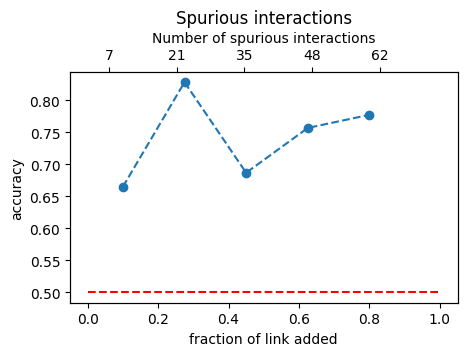

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(p_list, scores, 'o--')
ax.hlines(0.5, 0, 1, color='red', linestyle='--')
ax.set_xlabel("fraction of link added")
ax.set_ylabel("accuracy")
ax.set_title("Spurious interactions")

axsec = ax.twiny()
axsec.set_xticks(p_list)
axsec.set_xticklabels(spur_int)
axsec.set_xlabel("Number of spurious interactions")


### Visual

/home/ubuntu/.local/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


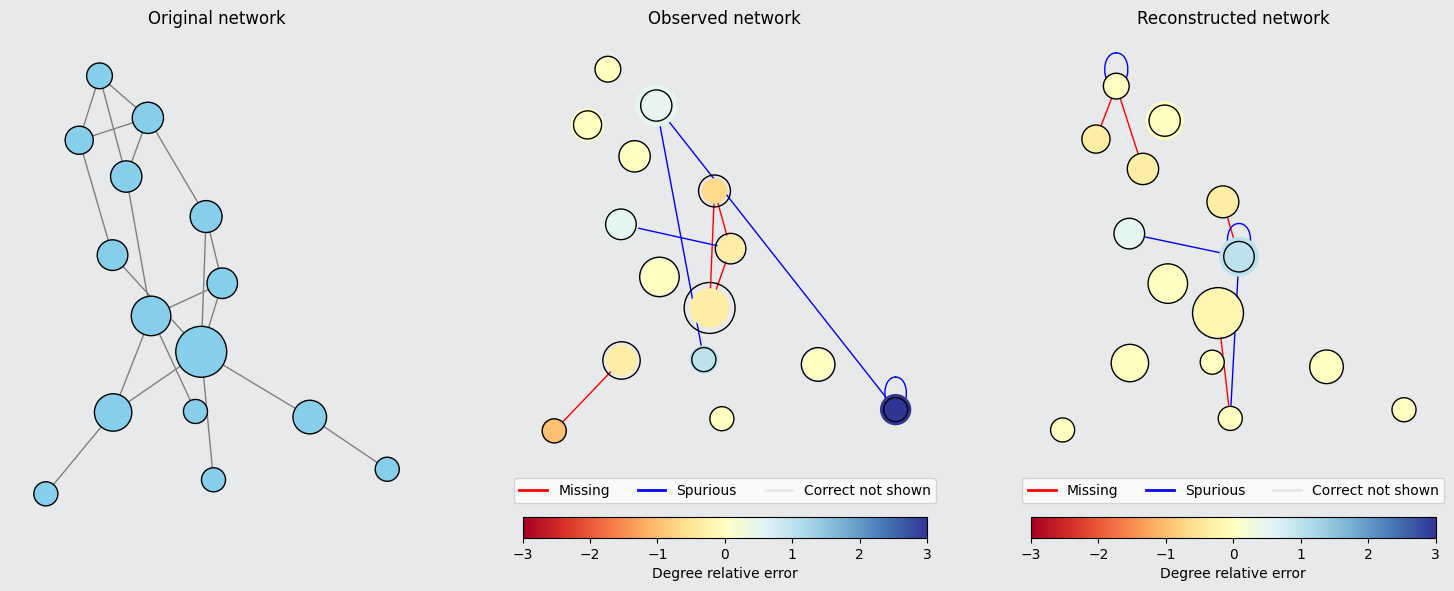

In [6]:
G = nx.florentine_families_graph().to_undirected()
#G = nx.karate_club_graph().to_undirected()
A = nx.adjacency_matrix(G).todense()
del G
A_obs = corruptAdjacencyMatrix(A, p=0.4, mode='both')
A_tilde = corruptAdjacencyMatrix(A, p=0.4, mode='both')

fig, ax = plotGraphsComparison(A, A_obs, A_tilde)
fig.show()